In [27]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from frouros.datasets.synthetic import SEA
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics.prequential_error import PrequentialError


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
random_state = 31
np.random.seed(random_state)

# Load and preprocess the CSV data
data = pd.read_csv('EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv').head(100000)
data = data[['close']]
data = np.log(data / data.shift(1))
data = data.dropna()
scaler = StandardScaler()
scaled_result = scaler.fit_transform(data.values.reshape(-1, 1))
data['close'] = pd.Series(scaled_result.flatten())
data['target'] = data['close'].shift(-1).dropna()
data = data.dropna()

# Print the first few rows of the target column
print("First few rows of the target column:")
print(data['target'].head())

# Extract features and target
X_reference = data[['close']].values
y_reference = data['target'].values.reshape(-1, 1)

# Shuffle data to avoid bias
idx = np.arange(len(X_reference))
np.random.shuffle(idx)
X_reference, y_reference = X_reference[idx], y_reference[idx]

# Split the data into training and warm-up sets
split_idx = len(X_reference) // 2  # 50% each subset (train and warmup)
X_train, y_train = X_reference[:split_idx], y_reference[:split_idx]
X_warmup, y_warmup = X_reference[split_idx:], y_reference[split_idx:]

# Print the split data
print("\nTraining Data:")
print("X_train:", X_train[:5])  # Print first 5 rows for brevity
print("y_train:", y_train[:5])  # Print first 5 rows for brevity

print("\nWarm-up Data:")
print("X_warmup:", X_warmup[:5])  # Print first 5 rows for brevity
print("y_warmup:", y_warmup[:5])  # Print first 5 rows for brevity

First few rows of the target column:
1   -0.256345
2    0.345629
3    2.151277
4   -1.288079
5    0.947458
Name: target, dtype: float64

Training Data:
X_train: [[ 0.08895539]
 [ 0.7793466 ]
 [-0.78496388]
 [ 0.26376335]
 [ 0.60753345]]
y_train: [[-0.08566675]
 [ 0.95208597]
 [-0.17316603]
 [ 0.08901578]
 [-0.25801789]]

Warm-up Data:
X_warmup: [[-0.68512641]
 [-0.43697487]
 [ 0.08782592]
 [ 0.94523472]
 [ 0.08773105]]
y_warmup: [[ 0.08749328]
 [-0.4369944 ]
 [-0.08453728]
 [-2.82939802]
 [ 1.72322092]]


In [10]:
test_concepts = [generator.generate_dataset(
    block=block,
    noise=noise,
    num_samples=10000,
) for block in [1, 3]]  # Concepts 1 and 3

X_test, y_test = [], []
for concept in test_concepts:
    for sample, label in concept:
        X_test.append(sample)
        y_test.append(label)

X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)


In [24]:
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=len(X_warmup),  # Minimum number of instances to start checking for drift
)

detector = DDM(
    config=config,
)

In [28]:
model = DecisionTreeRegressor(
    random_state=random_state,
)
model.fit(
    X=X_train,
    y=y_train,
)


DecisionTreeRegressor(random_state=31)

In [29]:
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"α={alpha}",
    )
    for alpha in [1.0, 0.9999, 0.999]
]
metrics_historic_detector = {f"{metric.name}": [] for metric in metrics}


In [30]:
def error_scorer(y_true, y_pred):  # Error function
    return 1 - (y_true.item() == y_pred.item())


In [31]:
# Warm-up detector
print(f"Warming up detector with {len(X_warmup)} samples")

for X, y in zip(X_warmup, y_warmup):
    y_pred = model.predict(X=X.reshape(1, -1))
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)

    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))


Warming up detector with 49999 samples


In [32]:
idx_drift, idx_warning = [], []
i = len(X_warmup)
for X, y in zip(X_test, y_test):
    y_pred = model.predict(X=X.reshape(1, -1))  # Model's prediction
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    status = detector.status
    if status["drift"]:
        # Drift detected
        print(f"Drift detected at index: {i}")
        idx_drift.append(i)
        detector.reset()  # Reset detector
        for metric in metrics:  # Reset metrics
            metric.reset()
        break  # Stop simulation
    elif status["warning"]:
        # Warning zone
        idx_warning.append(i)
    i += 1


ValueError: X has 3 features, but DecisionTreeRegressor is expecting 1 features as input.

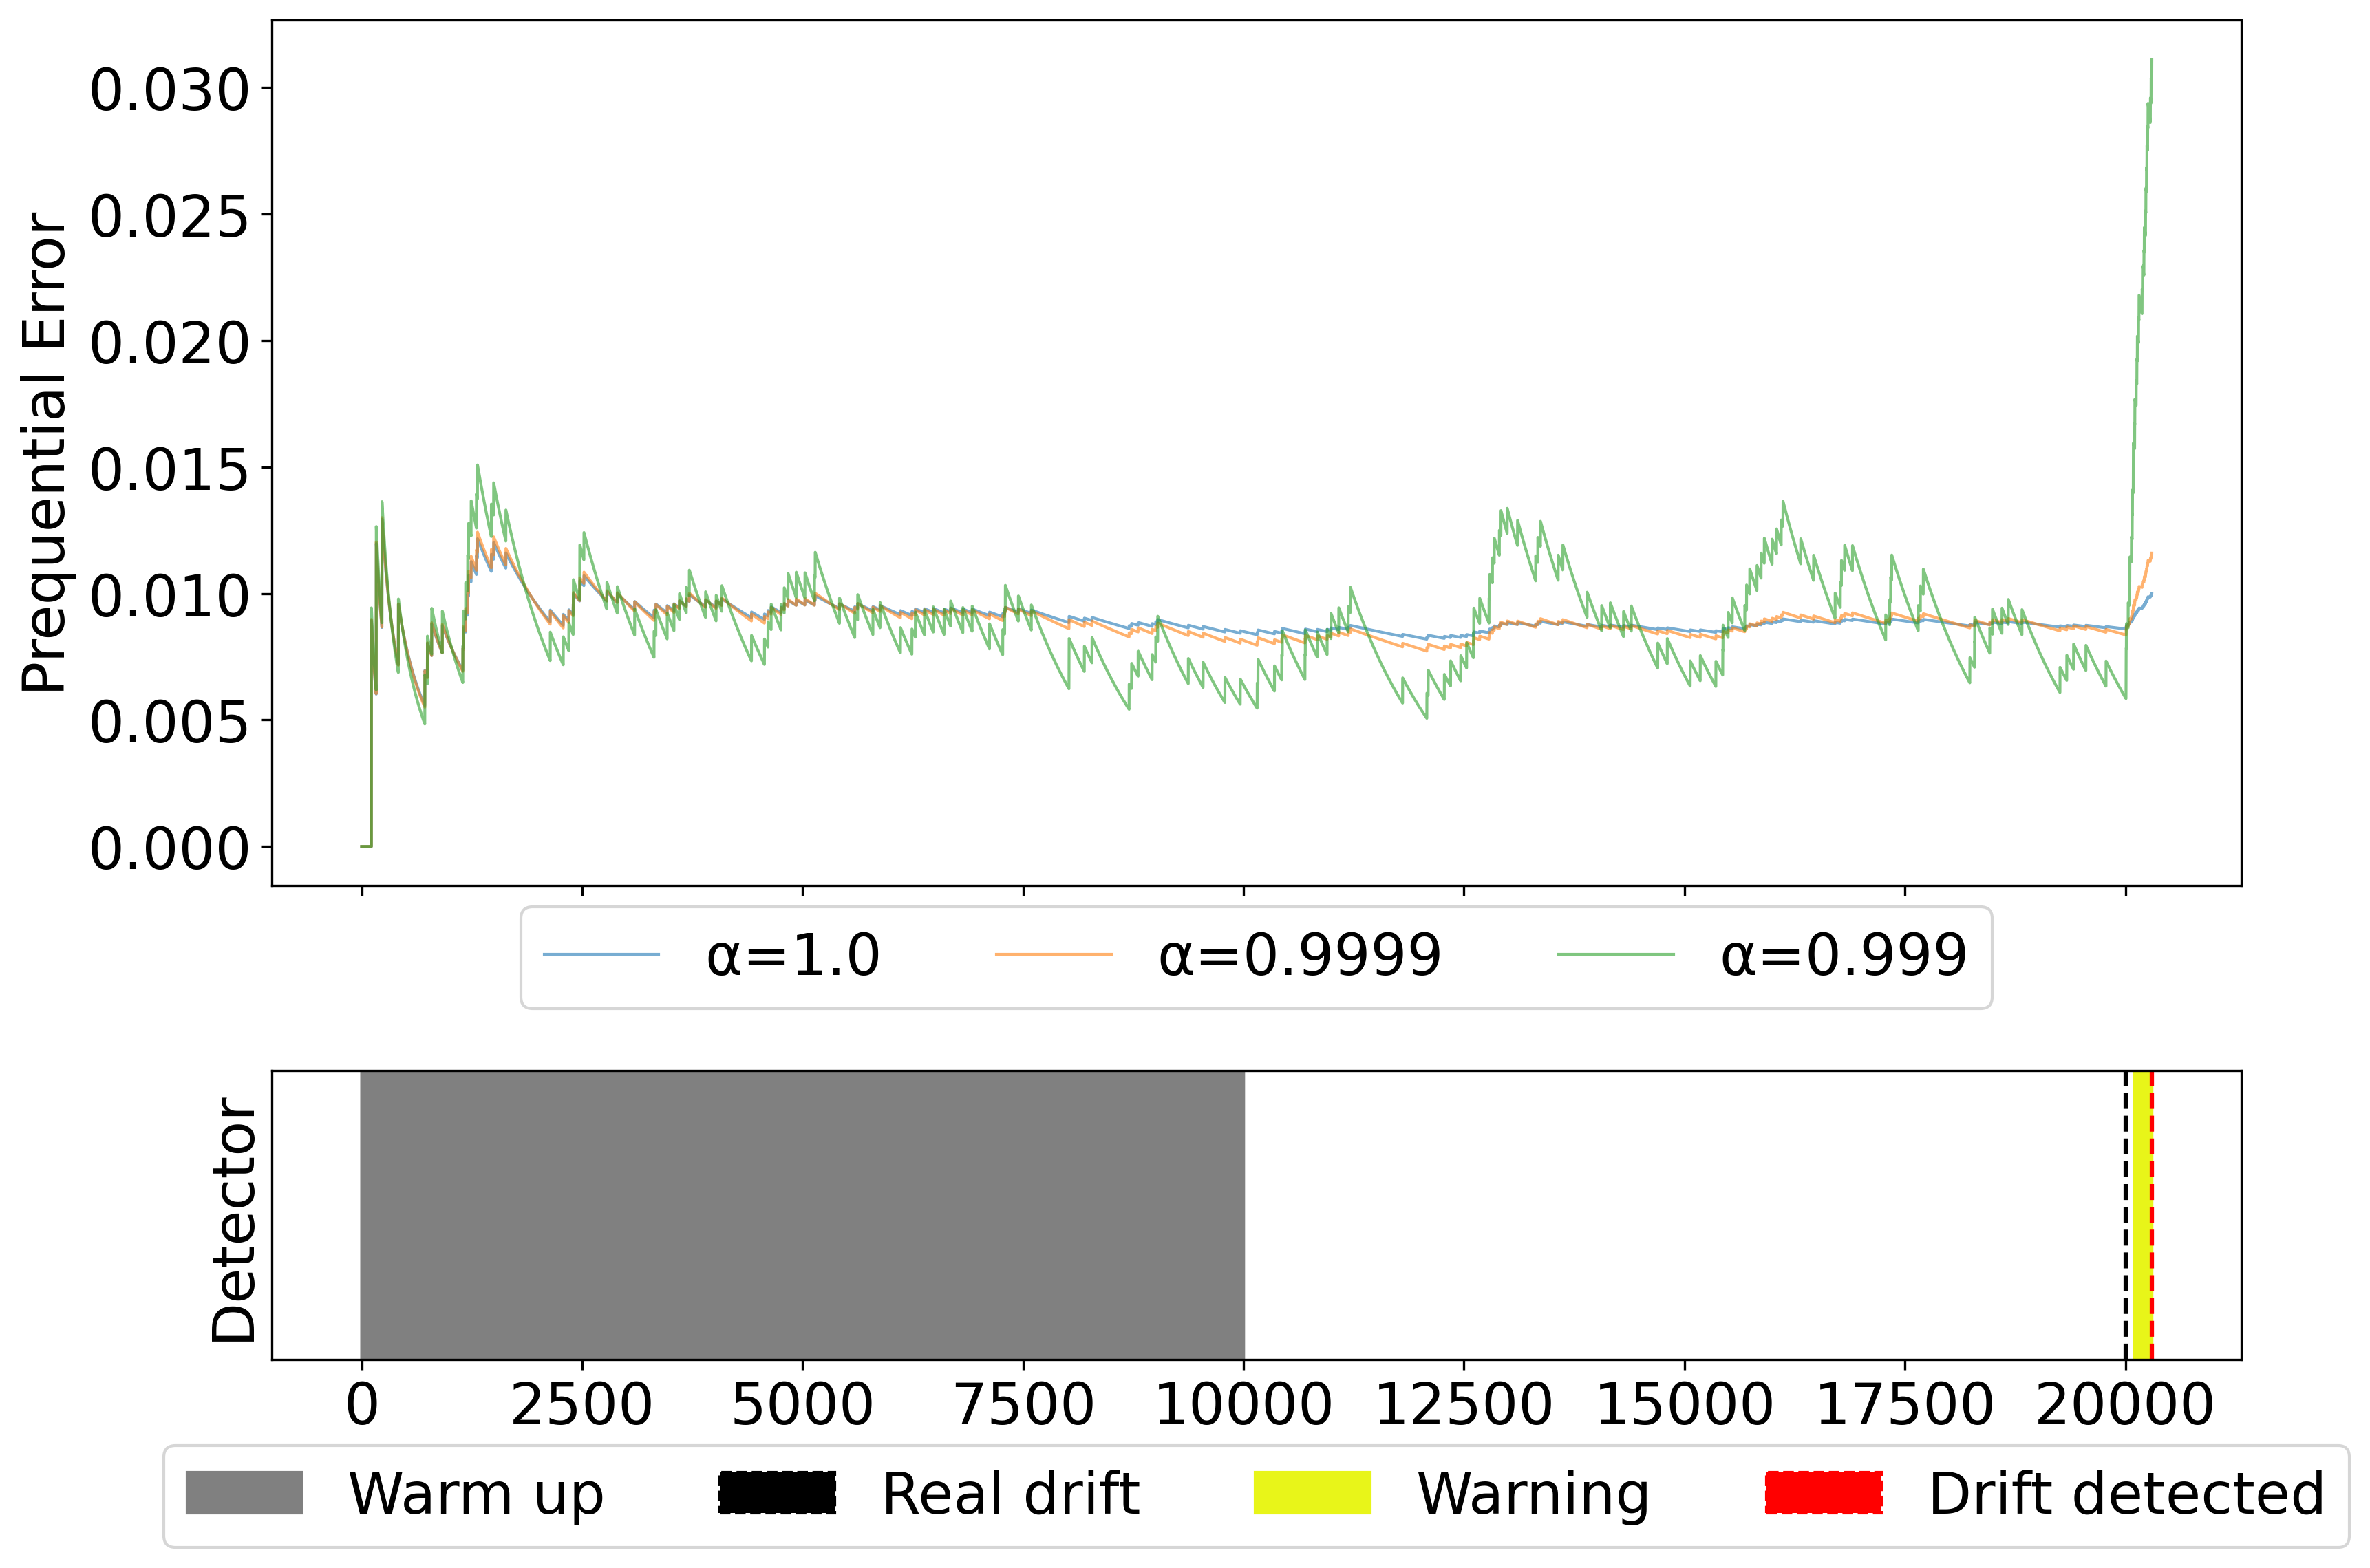

In [19]:
plt.rcParams.update({'font.size': 20})

alpha = 0.6
linewidth = 1.0

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    dpi=300,
    gridspec_kw={'height_ratios': [3, 1]},
)

for (metric_name, metric_values), linecolor in zip(
        metrics_historic_detector.items(),
        ["#1f77b4", "#ff7f0e", "#2ca02c"],
):
    ax[0].plot(metric_values,
               color=linecolor,
               linewidth=linewidth,
               alpha=alpha,
               label=metric_name)

drift_color = "red"
drift_linestyle = "--"
warmup_color = "grey"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in range(0, len(X_warmup)):
    ax[1].axvline(x=idx,
                  color=warmup_color,
                  linewidth=linewidth)

for idx in idx_warning:
    ax[1].axvline(x=idx,
                  color=warning_color,
                  linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx,
                  color=drift_color,
                  linestyle=drift_linestyle,
                  linewidth=1.5)

ax[0].set_ylabel("Prequential Error")
ax[0].legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.175),
    fancybox=True,
)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(color=drift_color, label="Drift detected", linestyle=drift_linestyle)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
warmup_path = mpatches.Patch(color=warmup_color, label="Warm up")
real_drift_path = mpatches.Patch(color=real_drift_color, label="Real drift", linestyle=drift_linestyle)
ax[1].axvline(x=20000,
              color=real_drift_color,
              linestyle=drift_linestyle,
              linewidth=1.5)
ax[1].legend(
    handles=[warmup_path, real_drift_path, warning_path, drift_path],
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
)

fig.tight_layout()
plt.show()


First few rows of the target column:
1   -0.256345
2    0.345629
3    2.151277
4   -1.288079
5    0.947458
Name: target, dtype: float64

Training Data:
X_train: [[ 0.08895539]
 [ 0.7793466 ]
 [-0.78496388]
 [ 0.26376335]
 [ 0.60753345]]
y_train: [[-0.08566675]
 [ 0.95208597]
 [-0.17316603]
 [ 0.08901578]
 [-0.25801789]]

Warm-up Data:
X_warmup: [[-0.68512641]
 [-0.43697487]
 [ 0.08782592]
 [ 0.94523472]
 [ 0.08773105]]
y_warmup: [[ 0.08749328]
 [-0.4369944 ]
 [-0.08453728]
 [-2.82939802]
 [ 1.72322092]]
Warming up detector with 49999 samples
Drift detected at index: 96123
All error rates during the test phase:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

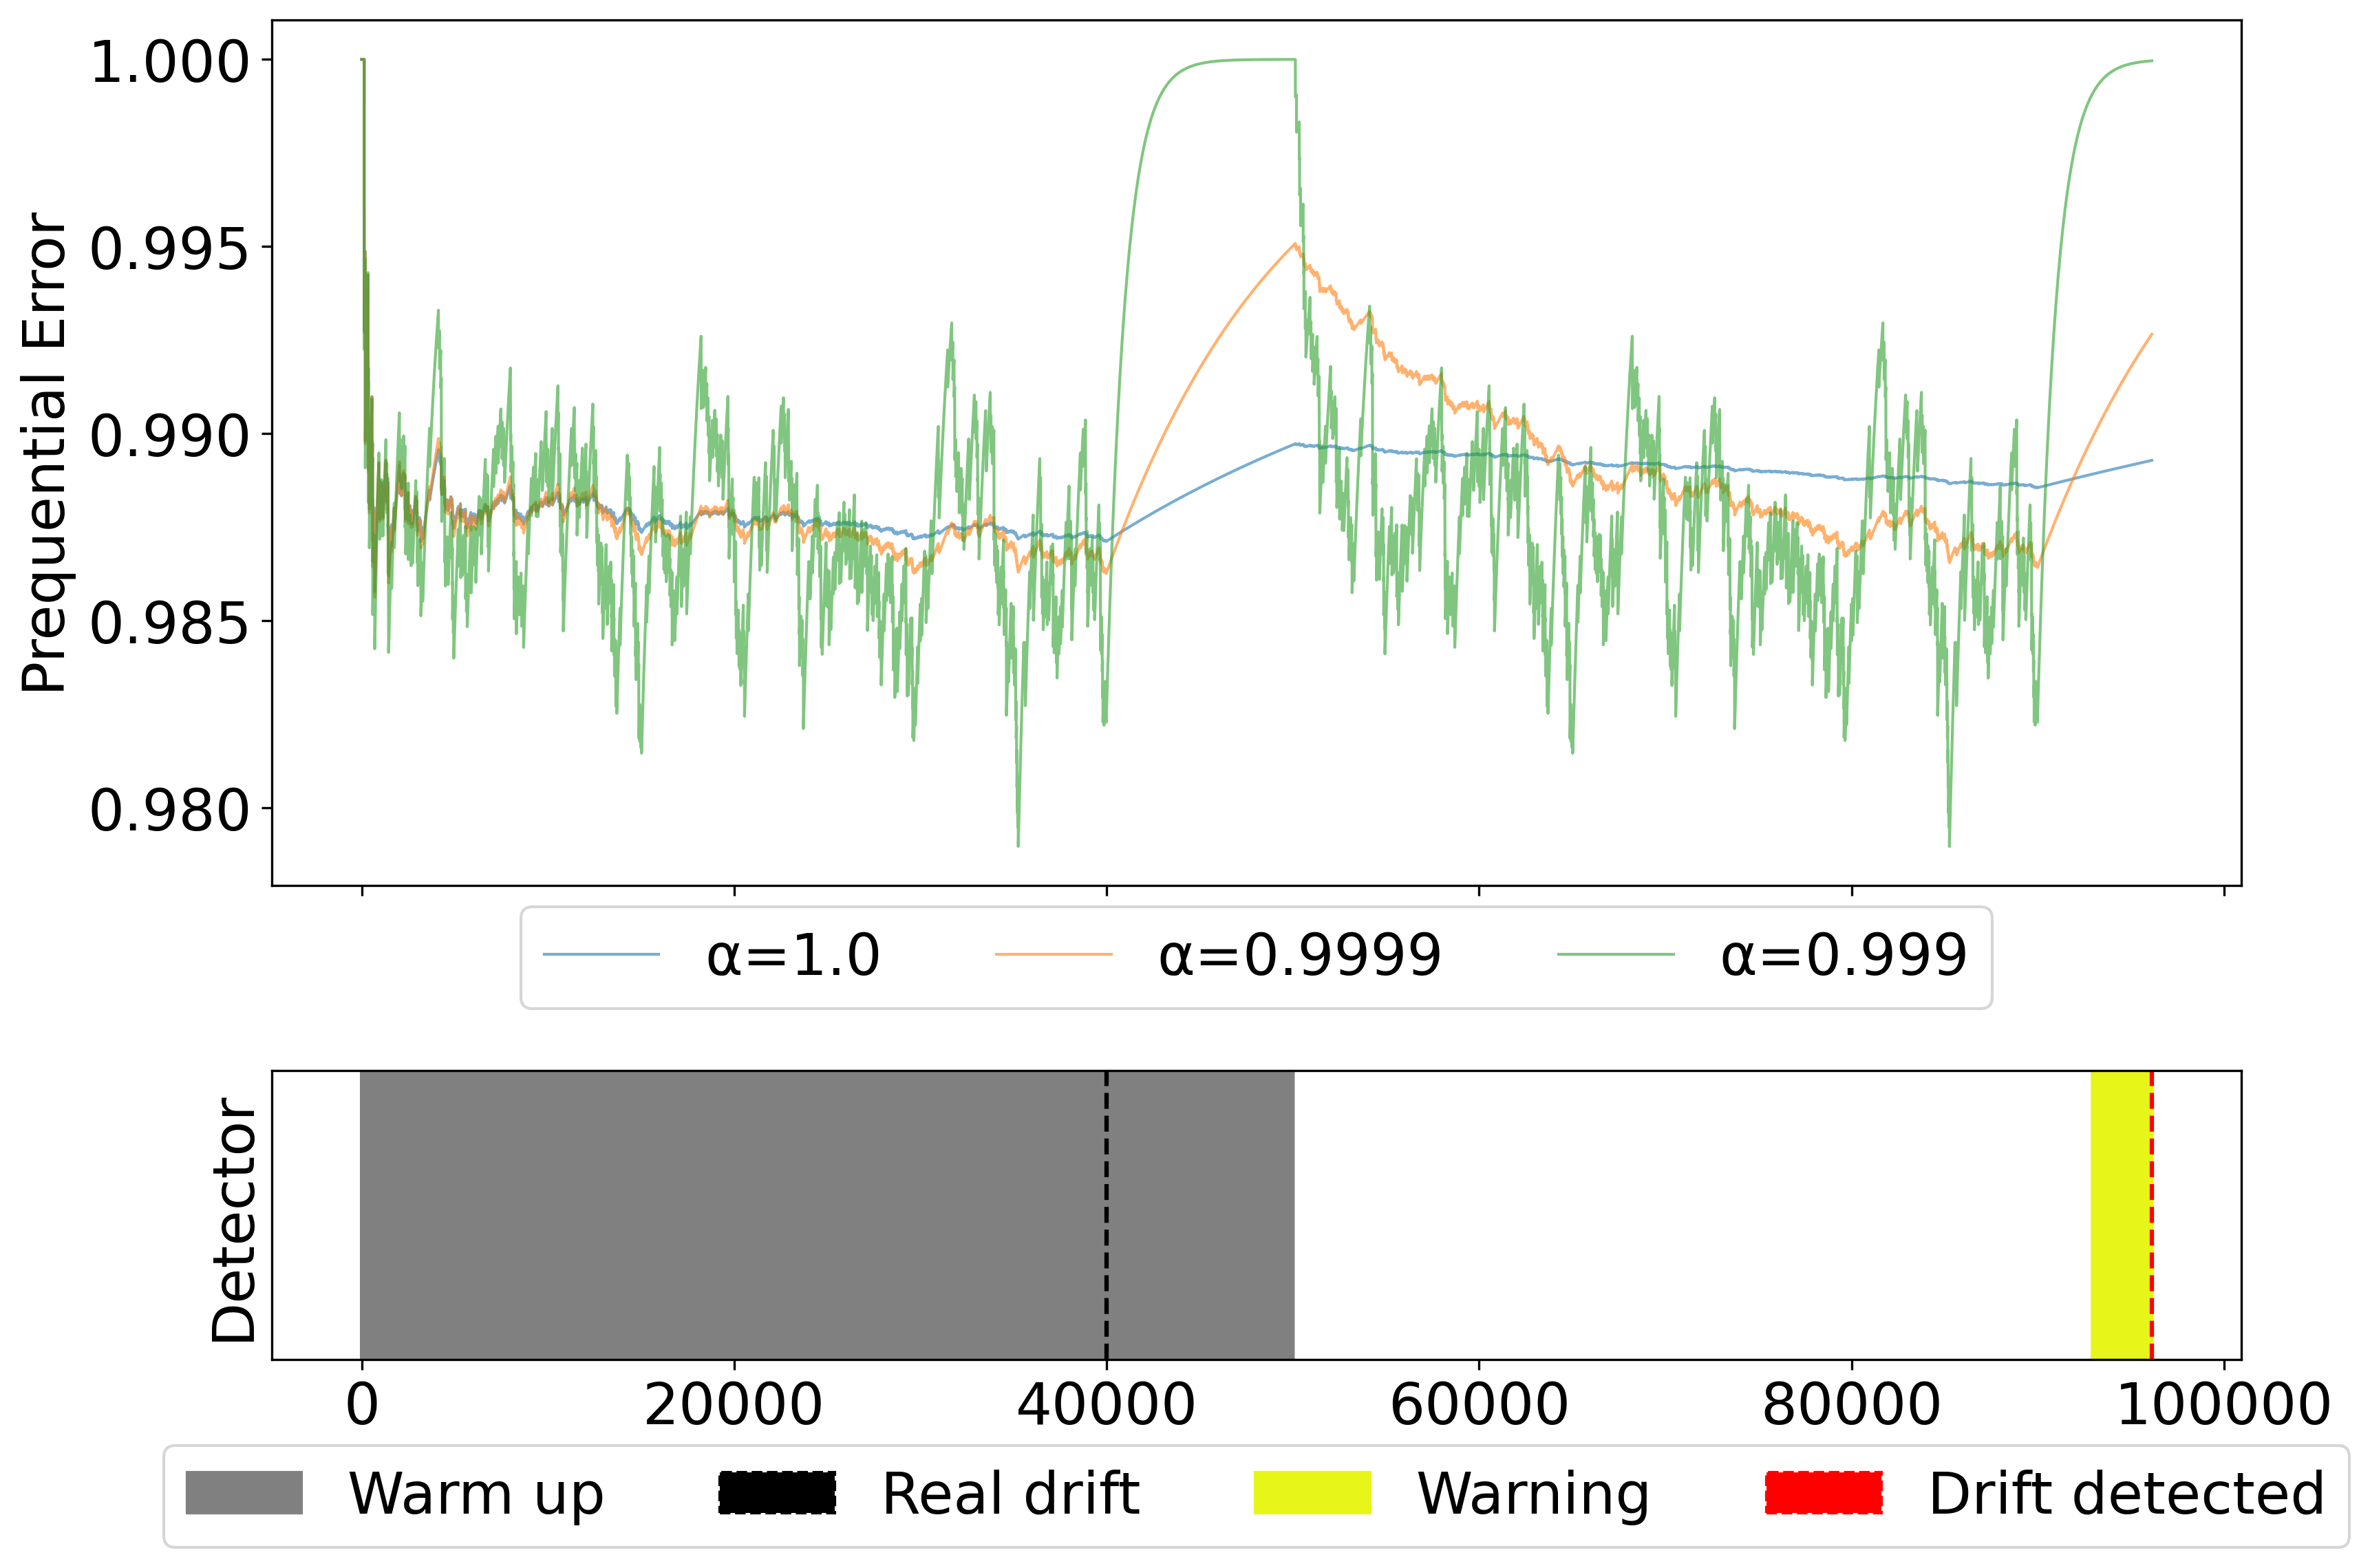

In [35]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics import PrequentialError
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set random seed for reproducibility
random_state = 31
np.random.seed(random_state)

# Load and preprocess the CSV data
data = pd.read_csv('EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv').head(100000)
data = data[['close']]
data = np.log(data / data.shift(1))
data = data.dropna()
scaler = StandardScaler()
scaled_result = scaler.fit_transform(data.values.reshape(-1, 1))
data['close'] = pd.Series(scaled_result.flatten())
data['target'] = data['close'].shift(-1).dropna()
data = data.dropna()

# Print the first few rows of the target column
print("First few rows of the target column:")
print(data['target'].head())

# Extract features and target
X_reference = data[['close']].values
y_reference = data['target'].values.reshape(-1, 1)

# Shuffle data to avoid bias
idx = np.arange(len(X_reference))
np.random.shuffle(idx)
X_reference, y_reference = X_reference[idx], y_reference[idx]

# Split the data into training and warm-up sets
split_idx = len(X_reference) // 2  # 50% each subset (train and warmup)
X_train, y_train = X_reference[:split_idx], y_reference[:split_idx]
X_warmup, y_warmup = X_reference[split_idx:], y_reference[split_idx:]

# Print the split data
print("\nTraining Data:")
print("X_train:", X_train[:5])  # Print first 5 rows for brevity
print("y_train:", y_train[:5])  # Print first 5 rows for brevity

print("\nWarm-up Data:")
print("X_warmup:", X_warmup[:5])  # Print first 5 rows for brevity
print("y_warmup:", y_warmup[:5])  # Print first 5 rows for brevity

# Define and fit model
model = DecisionTreeRegressor(random_state=random_state)
model.fit(X=X_train, y=y_train)

# Split the remaining data into test set
X_test, y_test = X_warmup, y_warmup

# Introduce artificial drift in the last 20% of the test data
drift_size = int(len(X_test) * 0.2)
y_test[-drift_size:] += np.random.normal(0, 0.5, size=(drift_size, 1))

# Detector configuration and instantiation
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=len(X_warmup),  # Minimum number of instances to start checking for drift
)
detector = DDM(config=config)

# Metric to compute accuracy
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"α={alpha}",
    )
    for alpha in [1.0, 0.9999, 0.999]
]
metrics_historic_detector = {f"{metric.name}": [] for metric in metrics}

def error_scorer(y_true, y_pred):  # Error function
    return 1 - (y_true.item() == y_pred.item())

# Warm-up detector
print(f"Warming up detector with {len(X_warmup)} samples")

for X, y in zip(X_warmup, y_warmup):
    y_pred = model.predict(X.reshape(1, -1))
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)

    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

idx_drift, idx_warning = [], []
i = len(X_warmup)
errors = []  # List to store all errors
for X, y in zip(X_test, y_test):
    y_pred = model.predict(X.reshape(1, -1))  # Model's prediction
    error = error_scorer(y_true=y, y_pred=y_pred)
    errors.append(error)  # Store the error
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    status = detector.status
    if status["drift"]:
        # Drift detected
        print(f"Drift detected at index: {i}")
        idx_drift.append(i)
        detector.reset()  # Reset detector
        for metric in metrics:  # Reset metrics
            metric.reset()
        break  # Stop simulation
    elif status["warning"]:
        # Warning zone
        idx_warning.append(i)
    i += 1

# Print all errors
print("All error rates during the test phase:")
print(errors)

plt.rcParams.update({'font.size': 20})

alpha = 0.6
linewidth = 1.0

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    dpi=300,
    gridspec_kw={'height_ratios': [3, 1]},
)

for (metric_name, metric_values), linecolor in zip(
        metrics_historic_detector.items(),
        ["#1f77b4", "#ff7f0e", "#2ca02c"],
):
    ax[0].plot(metric_values,
               color=linecolor,
               linewidth=linewidth,
               alpha=alpha,
               label=metric_name)

drift_color = "red"
drift_linestyle = "--"
warmup_color = "grey"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in range(0, len(X_warmup)):
    ax[1].axvline(x=idx,
                  color=warmup_color,
                  linewidth=linewidth)

for idx in idx_warning:
    ax[1].axvline(x=idx,
                  color=warning_color,
                  linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx,
                  color=drift_color,
                  linestyle=drift_linestyle,
                  linewidth=1.5)

ax[0].set_ylabel("Prequential Error")
ax[0].legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.175),
    fancybox=True,
)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(color=drift_color, label="Drift detected", linestyle=drift_linestyle)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
warmup_path = mpatches.Patch(color=warmup_color, label="Warm up")
real_drift_path = mpatches.Patch(color=real_drift_color, label="Real drift", linestyle=drift_linestyle)
ax[1].axvline(x=len(X_test) - drift_size,
              color=real_drift_color,
              linestyle=drift_linestyle,
              linewidth=1.5)
ax[1].legend(
    handles=[warmup_path, real_drift_path, warning_path, drift_path],
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
)

fig.tight_layout()
plt.show()